Getting the energy functions to work

In [1]:
type LatticeSite
    A::Array{Float64,1}  # Fluctuating vector potential
    θ⁺::Float64 # Phase of the + component
    θ⁻::Float64 # Phase of the - component
    u⁺::Float64 # Amplitude of + component
end
type State
    lattice::Array{LatticeSite,2}  # Numerical lattice
    γ::Float64    # Order parameter amplitude
    g::Float64    # Gauge coupling
    ν::Float64    # Anisotropy constant
    f::Float64    # Magnetic filling fraction
end
function initializeState(N::Int64, choice::Int64)
    N <= 1 && throw(DomainError())
    
    # Constants
    γ = 1.0    # Order parameter amplitude
    g = 1.0    # Gauge coupling
    ν = 0.0    # Anisotropy constant
    f = 0.0    # Magnetic filling fraction
    
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
        lattice = [LatticeSite([rand()*Amax*(-1)^rand(0:1),rand()*Amax*(-1)^rand(0:1)],
                rand()*2*π,rand()*2*π, rand()) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end
import Base.copy
function copy(ϕ::LatticeSite)
    LatticeSite([ϕ.A[1],ϕ.A[2]],ϕ.θ⁺,ϕ.θ⁻,ϕ.u⁺)
end
function copy(ψ::State)
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    lattice = [LatticeSite([ψ.lattice[y,x].A[1],ψ.lattice[y,x].A[2]],ψ.lattice[y,x].θ⁺,ψ.lattice[y,x].θ⁻,
            ψ.lattice[y,x].u⁺) for y = 1:Ly, x=1:Lx]
    State(lattice, ψ.γ, ψ.g, ψ.ν, ψ.f)
end

copy (generic function with 46 methods)

In [2]:
function fᵣ(ϕ::LatticeSite,ϕᵣ₊₁::LatticeSite,ϕᵣ₊₂::LatticeSite,A₀::Float64,γ::Float64,g::Float64,ν::Float64,f::Float64)
    energy = 0
    uᵣ₊₁⁻ = √(1-ϕᵣ₊₁.u⁺^2)
    u⁻ = √(1-ϕ.u⁺^2)
    uᵣ₊₂⁻ = √(1-ϕᵣ₊₂.u⁺^2)
    A₂ = ϕ.A[2]+A₀
    # Kinetic energy Fₖ
    energy += -2*γ^2*(ϕᵣ₊₁.u⁺ *ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁺ + g*ϕ.A[1]) 
        + ϕᵣ₊₂.u⁺*ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁺ + g*A₂) 
        + uᵣ₊₁⁻*u⁻*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁻ + g*ϕ.A[1]) 
        + uᵣ₊₂⁻*u⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁻ + g*A₂) )
    # Potential energy Fᵥ
    energy += γ^4*ϕ.u⁺^2*u⁻^2*(1+ν*cos(2*(ϕ.θ⁺-ϕ.θ⁻)))
    # Andreev Bashkin terms
    energy += γ^2*(ν+1)*(u⁻*ϕᵣ₊₂.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ + g*A₂) 
        + ϕ.u⁺*uᵣ₊₂⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ + g*A₂) 
        - u⁻*ϕᵣ₊₁.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ + g*ϕ.A[1]) 
        - ϕ.u⁺*uᵣ₊₁⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ + g*ϕ.A[1]))
    # Mixed gradient terms
    energy += γ^2*(ν-1)*(ϕᵣ₊₂.u⁺*uᵣ₊₁⁻*sin(ϕᵣ₊₁.θ⁻ - ϕᵣ₊₂.θ⁺ + g*(ϕ.A[1]-A₂)) 
        - uᵣ₊₂⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕᵣ₊₂.θ⁻ + g*(ϕ.A[1] - A₂)) 
        + 2*ϕ.u⁺*u⁻*sin(ϕ.θ⁻-ϕ.θ⁺) 
        -  u⁻*ϕᵣ₊₂.u⁺*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ + g*A₂) 
        + ϕ.u⁺*uᵣ₊₂⁻*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ + g*A₂) 
        + u⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ + g*ϕ.A[1]) 
        - ϕ.u⁺*uᵣ₊₁⁻*sin(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ + g*ϕ.A[1]))
    energy
end

fᵣ (generic function with 1 method)

In [3]:
# Loops over all positions of the lattice of a state and calculates the total energy from the
# Higgs-field terms using the function fᵣ() + the energy from the gauge field.
function E(ψ::State)
    γ = ψ.γ
    g = ψ.g
    energy = 0.0
    ν = ψ.ν
    f = ψ.f
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    
    # Contribution from upper right corner
    A⁰ = (Lx-1)*2π*f
    ϕ = ψ.lattice[1,Lx]    # Lattice site at upper right corner
    ϕᵣ₊₁ = ψ.lattice[1,1]    # Nearest neighbor at r+x is upper left corner
    ϕᵣ₊₂ = ψ.lattice[Ly,Lx]  # Nearest neighbor at r+y is lower right corner
    energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
    energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2 # Maxwell term
    
    # Contribution from right boundary paralell to y-axis
    # except for the upper right corneϕ.
    for y=2:Ly
        ϕ = ψ.lattice[y,Lx]
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,Lx]
        A⁰ = (Lx-1)*2*π*f
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
    end
    
    # Contribution from the bulk of lattice sites and upper boundary
    for x=1:(Lx-1)
        A⁰ = (x-1)*2*π*f        # Constant vector potential.
        # Constribution from upper boundary except upper right corner
        ϕ = ψ.lattice[1,x]
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[Ly,x]
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
        
        # Contribution from the rest of the bulk.
        for y=2:Ly
            ϕ = ψ.lattice[y,x]          # Lattice site at position r
            ϕᵣ₊₁ = ψ.lattice[y,x+1]       # Nearest neighbor at r+x
            ϕᵣ₊₂ = ψ.lattice[y-1,x]       # Nearest neighbor at r+y
            
            energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
            energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
        end
    end
    
    energy
end

E (generic function with 1 method)

Let's do a unit test that the energy function acts as expected.

In [4]:
# Tests mostly that the kinetic energy Fₖ is correctly calculated.
using Base.Test
f = 1.0/33
ψ = initializeState(2, 1)
@test E(ψ) == -4*(3+cos(2*π*1/32))

Test Failed
  Expression: E(ψ) == -4 * (3 + cos((2 * π * 1) / 32))
   Evaluated: -16.0 == -15.923141121612922


LoadError: [91mThere was an error during testing[39m

In [5]:
# If we don't try to be fancy about it, we could just use fᵣ for each of the points around the
# updated lattice site.
#
function ΔE2(ψ::State, ϕ′::LatticeSite, pos::Array{Int64,1})
    x = pos[1]
    y = pos[2]
    Ly = size(ψ.lattice,1)
    Lx = size(ψ.lattice,2)
    δE = 0.0
    ϕ = ψ.lattice[y,x]
    
    # Calculate nearest neighbor lattice sites.
    const ϕᵣ₊₁ = ψ.lattice[y, mod(x,Lx)+1]
    const ϕᵣ₊₂ = ψ.lattice[mod(y-2,Ly)+1,x]
    const ϕᵣ₋₁ = ψ.lattice[y,mod(x-2,Lx)+1]
    const ϕᵣ₋₂ = ψ.lattice[mod(y,Ly)+1,x]
    const ϕᵣ₋₁₊₂ = ψ.lattice[mod(y-2,Ly)+1,mod(x-2,Lx)+1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[mod(y,Ly)+1,mod(x,Lx)+1]
    
    # Energy difference from Higgs field terms
    # First contribution from current position.
    δE += fᵣ(ϕ′,ϕᵣ₊₁,ϕᵣ₊₂,2π*ψ.f*(x-1),ψ.γ,ψ.g,ψ.ν,ψ.f)-fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,2π*ψ.f*(x-1),ψ.γ,ψ.g,ψ.ν,ψ.f)
    # Then from position r-x
    δE += fᵣ(ϕᵣ₋₁,ϕ′,ϕᵣ₋₁₊₂,2π*ψ.f*(x-2),ψ.γ,ψ.g,ψ.ν,ψ.f)-fᵣ(ϕᵣ₋₁,ϕ,ϕᵣ₋₁₊₂,2π*ψ.f*(x-2),ψ.γ,ψ.g,ψ.ν,ψ.f)
    # Then from position r-y
    δE += fᵣ(ϕᵣ₋₂,ϕᵣ₋₂₊₁,ϕ′,2π*ψ.f*(x-1),ψ.γ,ψ.g,ψ.ν,ψ.f)-fᵣ(ϕᵣ₋₂,ϕᵣ₋₂₊₁,ϕ,2π*ψ.f*(x-1),ψ.γ,ψ.g,ψ.ν,ψ.f)
    
    # Then calculate the Gauge field contribution
    # First contribution from current position
    δE += (ϕ′.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ′.A[2])^2 - (ϕ.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ.A[2])^2
    # Then from position r-x
    δE += (ϕᵣ₋₁.A[1] + ϕ′.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2 - (ϕᵣ₋₁.A[1] + ϕ.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2
    # Then from position r-y
    δE += (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ′.A[1] - ϕᵣ₋₂.A[2])^2 - (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ.A[1] - ϕᵣ₋₂.A[2])^2
end 

ΔE2 (generic function with 1 method)

In [79]:
# Now we try to be fancy about it and use the reduced formula for the difference between the energies
#
function ΔE3(ψ::State, ϕ′::LatticeSite, pos::Array{Int64,1})
    const x = pos[1]
    const y = pos[2]
    const Ly = size(ψ.lattice,1)
    const Lx = size(ψ.lattice,2)
    const ϕ = ψ.lattice[y,x]
    const g = ψ.g
    const δE::Float64 = 0.0
    
    # Calculate nearest neighbor lattice sites.
    const ϕᵣ₊₁ = ψ.lattice[y, mod(x,Lx)+1]
    const ϕᵣ₊₂ = ψ.lattice[mod(y-2,Ly)+1,x]
    const ϕᵣ₋₁ = ψ.lattice[y,mod(x-2,Lx)+1]
    const ϕᵣ₋₂ = ψ.lattice[mod(y,Ly)+1,x]
    const ϕᵣ₋₁₊₂ = ψ.lattice[mod(y-2,Ly)+1,mod(x-2,Lx)+1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[mod(y,Ly)+1,mod(x,Lx)+1]
    
    # Calculate u⁻ for these lattice sites
    const u′⁻ = √(1-ϕ′.u⁺^2)
    const u⁻ = √(1-ϕ.u⁺^2)
    const u⁻ᵣ₊₁ = √(1-ϕᵣ₊₁.u⁺^2)
    const u⁻ᵣ₊₂ = √(1-ϕᵣ₊₂.u⁺^2)
    const u⁻ᵣ₋₁ = √(1-ϕᵣ₋₁.u⁺^2)
    const u⁻ᵣ₋₂ = √(1-ϕᵣ₋₂.u⁺^2)
    const u⁻ᵣ₋₁₊₂ = √(1-ϕᵣ₋₁₊₂.u⁺^2)
    const u⁻ᵣ₋₂₊₁ = √(1-ϕᵣ₋₂₊₁.u⁺^2)
    
    # Calculate constant link variables
    const A⁰ = 2π*ψ.f*(x-1)
    const A⁰₊ = 2π*ψ.f*x
    const A⁰₋ = 2π*ψ.f*(x-2)
    
    # Normal kinetic terms
    δE += -2*ψ.γ^2*(ϕᵣ₊₁.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ′.θ⁺ + g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + g*ϕ.A[1]))
        + ϕᵣ₋₁.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₁*(u′⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ′.θ⁻ + g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ + g*ϕ.A[1]))
        + u⁻ᵣ₋₁*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + ϕᵣ₊₂.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ′.θ⁺ + g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + g*(ϕ.A[2]+A⁰)))
        + ϕᵣ₋₂.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)))
        + u⁻ᵣ₊₂*(u′⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ′.θ⁻ + g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ + g*(ϕ.A[2]+A⁰)))
        + u⁻ᵣ₋₂*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))))
    
    # Potential energy terms
    δE += ψ.γ^4*((ϕ′.u⁺*u′⁻)^2*(1+ψ.ν*cos(2*(ϕ′.θ⁺ - ϕ′.θ⁻))) - (ϕ.u⁺*u⁻)^2*(1+ψ.ν*cos(2*(ϕ.θ⁺ - ϕ.θ⁻))))
    
    # Andreev-Bashkin terms
    δE += ψ.γ^2*(ψ.ν+1)*(ϕᵣ₊₂.u⁺*(u′⁻*cos(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        - ϕᵣ₊₁.u⁺*(u′⁻*cos(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        + u⁻ᵣ₋₂*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - u⁻ᵣ₋₁*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₂*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        - u⁻ᵣ₊₁*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        + ϕᵣ₋₂.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - ϕᵣ₋₁.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
    
    # Mixed gradient terms
    δE += ψ.γ^2*(ψ.ν-1)*(ϕᵣ₊₂.u⁺*u⁻ᵣ₊₁*(sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -ϕᵣ₊₂.u⁺*(u′⁻*sin(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        +ϕᵣ₊₁.u⁺*(u′⁻*sin(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*sin(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        +u⁻ᵣ₋₂₊₁*(ϕ′.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ′.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - ϕ.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +ϕᵣ₋₁₊₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -u⁻ᵣ₋₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +u⁻ᵣ₋₁*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1])) 
        -(u⁻ᵣ₊₂*ϕᵣ₊₁.u⁺*(sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -u⁻ᵣ₊₂*(ϕ′.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        +u⁻ᵣ₊₁*(ϕ′.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        +ϕᵣ₋₂₊₁.u⁺*(u′⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ′.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - u⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +u⁻ᵣ₋₁₊₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -ϕᵣ₋₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +ϕᵣ₋₁.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
        +2*(ϕ′.u⁺*u′⁻*sin(ϕ′.θ⁻-ϕ′.θ⁺) - ϕ.u⁺*u⁻*sin(ϕ.θ⁻-ϕ.θ⁺)))
    
    # Then calculate the Gauge field contribution
    # First contribution from current position
    δE += (ϕ′.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ′.A[2])^2 - (ϕ.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ.A[2])^2
    # Then from position r-x
    δE += (ϕᵣ₋₁.A[1] + ϕ′.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2 - (ϕᵣ₋₁.A[1] + ϕ.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2
    # Then from position r-y
    δE += (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ′.A[1] - ϕᵣ₋₂.A[2])^2 - (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ.A[1] - ϕᵣ₋₂.A[2])^2
end

ΔE3 (generic function with 1 method)

In [33]:
# Test case. We make a 3x3 lattice, and put two different lattice sites in the middle
# i.e. the [2,2] position. Then we use the different functions to calculate the energy
# difference associated with this change.

ψ₂ = initializeState(3,2)
site = LatticeSite([0.0,0.0], 0, 0,1)
@show Ly = size(ψ₂.lattice,1)
ψ₁ = copy(ψ₂)
ψ₁.lattice[2,2] = copy(site)
@show ΔE2(ψ₂,site,[2,2])
@show ΔE3(ψ₂,site,[2,2])
@show E(ψ₁)-E(ψ₂)
@show ΔE2(ψ₂,site,[2,2]) == ΔE3(ψ₂,site,[2,2])
@show E(ψ₁)
@show isapprox(E(ψ₁)-E(ψ₂), ΔE3(ψ₂,site,[2,2]); atol=0.00000000000001e6, rtol=0)

Ly = size(ψ₂.lattice, 1) = 3
ΔE2(ψ₂, site, [2, 2]) = -1.8807743274874892e6
pos = [2, 2]
ΔE3(ψ₂, site, [2, 2]) = -1.8807743274874892e6
E(ψ₁) - E(ψ₂) = -1.8807743274874873e6
pos = [2, 2]
ΔE2(ψ₂, site, [2, 2]) == ΔE3(ψ₂, site, [2, 2]) = true
E(ψ₁) = 1.4612586570286604e7
pos = [2, 2]
isapprox(E(ψ₁) - E(ψ₂), ΔE3(ψ₂, site, [2, 2]); atol=1.0e-8, rtol=0) = true


true

It seems that the difference between using `E(ψ₁)-E(ψ₂)`and `ΔE2(ψ₂,site,[2,2])` is floating point error.

In [34]:
using BenchmarkTools
@benchmark ΔE2(ψ₂,site,[2,2])

BenchmarkTools.Trial: 
  memory estimate:  112 bytes
  allocs estimate:  2
  --------------
  minimum time:     1.803 μs (0.00% GC)
  median time:      1.829 μs (0.00% GC)
  mean time:        1.906 μs (0.00% GC)
  maximum time:     6.019 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [88]:
@benchmark ΔE3(ψ₂,site,[2,2])

BenchmarkTools.Trial: 
  memory estimate:  224 bytes
  allocs estimate:  9
  --------------
  minimum time:     1.302 μs (0.00% GC)
  median time:      1.320 μs (0.00% GC)
  mean time:        1.404 μs (2.39% GC)
  maximum time:     344.822 μs (97.52% GC)
  --------------
  samples:          10000
  evals/sample:     10

For some reason there seems to be a problem with `ΔE3` allocating memory to heap, but still it is faster than `ΔE2` because we are not wasting time summing 0es. Not sure how to prevent the memory issue

# Proposal of a local state update
Given a state $\Psi_i$ we want to propose a new state $\Psi_{i+1}$ that can later be accepted according to the Metropolis-Hastings algorithm. The proposal function thus has to take in a given state $\Psi_i$ and give out a new
state $\Psi_{i+1}$ as well as the energy difference between the two states since this can be effectively calculated depending on what kind of update is done to the state. Thus we don't need to call $E(\Psi)$ twice to find the difference in energy.

The local update is done at a particular lattice site where all degrees of freedom are updated, thus the function also has to know what lattice position to update.

Remember that the proposal probability for a new state $P(\Psi_i\to\Psi_j)$ has to be equal to the symmetric update

$$P(\Psi_i\to\Psi_j) = P(\Psi_j\to\Psi_i),$$

for the update to fulfill detailed balance.

So far we do a very simple thing of defining a fixed interval around the original value, from within which the new value is uniformly randomly picked. Given a value $\theta^+_\mathbf{r}$ at the lattice site $\mathbf{r}$, the new value 
$\theta'{}^+_\mathbf{r}$ is thus picked uniformly from the interval 
$$\theta'{}^+_\mathbf{r}\in(\theta^+_\mathbf{r}-\theta_\text{max},\;\theta^+_\mathbf{r}+\theta_\text{max})$$

In [36]:
using Distributions
function proposeLocalUpdate(ψᵢ::State, r::Array{Int64, 1})
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 3 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    const x = r[1]
    const y = r[2]
    (size(ψᵢ.lattice,1) < y || size(ψᵢ.lattice,2) < x) && throw(DomainError()) # r is outside the range of the lattice.
    
    # Save the lattice site at position r in a separate variable s.
    s = ψᵢ.lattice[y,x]
    
    # Construct new configuration at lattice site.
    newLatticeSite = LatticeSite([s.A[1]+rand(Uniform(-Amax,Amax)), s.A[2]+rand(Uniform(-Amax,Amax))],
        mod(s.θ⁺ + rand(Uniform(-θmax,θmax)), 2π), mod(s.θ⁻ + rand(Uniform(-θmax,θmax)), 2π), 
        mod(s.u⁺ + rand(Uniform(-umax,umax)),1))
    
    # Calculate energy difference between the two configurations and return this with the proposed lattice site.
    (newLatticeSite, ΔE3(ψᵢ,newLatticeSite,r))
end    

proposeLocalUpdate (generic function with 1 method)

# Metropolis Hastings update

Now we create a function that implements the acceptance step of the Metropolis Hastings algorithm.
1. From state $\Psi_i$, propose a new state $\Psi_{i+1}$
2. Calculate $\Delta E_{i,i+1}$.
3. Generate a random number r between $(0,1]$.
4. If $r\leq e^{-\beta\Delta E_{i,i+1}}$, accept the state

Since the 
> rand() 

function creates a random number in $[0,1)$ we create a random number in $(0,1]$ by mapping $0\mapsto1$.

In [37]:
function metropolisHastingUpdate!(ψ::State, r::Array{Int64,1}, β::Float64)
    (site, δE) = proposeLocalUpdate(ψ,r)
    
    # Create random number ran ∈ (0,1].
    ran = rand()
    if ran==0
        ran=1
    end
    
    # Update state with probability min(1, e^{-β⋅δE})
    # and return the energy of final state regardless of whether it gets updated or not.
    if log(ran) <= -β*δE
        ψ.lattice[r[2],r[1]] = site
        δE
    else
        δE = 0
    end
end

metropolisHastingUpdate! (generic function with 1 method)

# Monte Carlo sweep

Try to update the entire lattice once.

In [38]:
function mcSweep!(ψ::State, β::Float64)
    
    # Find size of the lattice L
    L = size(ψ.lattice,1)
    
    # Do a Metropolis-Hastings update for all lattice sites on the lattice.
    for x in 1:L, y in 1:L
        metropolisHastingUpdate!(ψ, [x,y], β)
    end
end

mcSweep! (generic function with 1 method)

Idea from Håvard: create all update values for the lattice in one function and all random numbers as well. Numbers needed are the LxL random numbers $\log(r),r\in(0,1]$ as well as new lattice sites for each lattice site in the lattice.

In [39]:
# Return an array of random numbers log(r) where r in (0,1]
function createLnUnif01(N::Int64)
    v = rand(N)
    for i=1:N
        if v[i]==0
            v[i] = 1
        end
        v[i] = log(v[i])
    end
    return v
end

createLnUnif01 (generic function with 1 method)

In [40]:
δran = [rand(Uniform(-1,1),2,2) for i=1:5]
δran[1][1] *= 2

0.4926322022031746

In [41]:
for y=1:3, x=5:7
    @show (y,x)
end

(y, x) = (1, 5)
(y, x) = (1, 6)
(y, x) = (1, 7)
(y, x) = (2, 5)
(y, x) = (2, 6)
(y, x) = (2, 7)
(y, x) = (3, 5)
(y, x) = (3, 6)
(y, x) = (3, 7)


In [71]:
# Generate new proposals for each site in ψ.lattice
function generateProposalLattice(ψ::State, Lx::Int64, Ly::Int64)
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 3 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    N = Lx*Ly
    
    # Create an array of matrices that contain δ-updates for each value of each lattice site
    # where each δ is in the interval [-maxValue, maxValue]
    δran = [rand(Uniform(-1,1),Ly,Lx) for i=1:5]
    for x=1:Lx, y=1:Ly
        δran[1][y,x] *= Amax
        δran[2][y,x] *= Amax
        δran[3][y,x] *= θmax
        δran[4][y,x] *= θmax
        δran[5][y,x] *= umax
    end
    
    newLattice = [LatticeSite([ψ.lattice[y,x].A[1] + δran[1][y,x], ψ.lattice[y,x].A[2] + δran[2][y,x]],
            mod(ψ.lattice[y,x].θ⁺ + δran[3][y,x],2π), mod(ψ.lattice[y,x].θ⁻ + δran[4][y,x],2π),
            mod(ψ.lattice[y,x].u⁺ + δran[5][y,x],1))
    for x=1:Lx, y=1:Ly]
end

generateProposalLattice (generic function with 1 method)

In [63]:
# Generate new proposals for each site in ψ.lattice
function generateProposalLattice2(ψ::State, Lx::Int64, Ly::Int64)
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 3 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    
    newLattice = [LatticeSite([ψ.lattice[y,x].A[1] + rand(Uniform(-1,1))*Amax, 
                ψ.lattice[y,x].A[2] + rand(Uniform(-1,1))*Amax],
            mod(ψ.lattice[y,x].θ⁺ + rand(Uniform(-1,1))*θmax,2π), mod(ψ.lattice[y,x].θ⁻ + rand(Uniform(-1,1))*θmax,2π),
            mod(ψ.lattice[y,x].u⁺ + rand(Uniform(-1,1))*umax,1))
    for x=1:Lx, y=1:Ly]
end

generateProposalLattice2 (generic function with 1 method)

In [44]:
# Generate new proposals for each site in ψ.lattice
function generateProposalLattice3(ψ::State, Lx::Int64, Ly::Int64)
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 3 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    newLattice = Array{LatticeSite}(Ly,Lx)
    for x=1:Lx
        for y=1:Ly
            newLattice[y,x] = LatticeSite([ψ.lattice[y,x].A[1] + rand(Uniform(-1,1))*Amax, 
                ψ.lattice[y,x].A[2] + rand(Uniform(-1,1))*Amax],
            ψ.lattice[y,x].θ⁺ + rand(Uniform(-1,1))*θmax, ψ.lattice[y,x].θ⁻ + rand(Uniform(-1,1))*θmax,
            ψ.lattice[y,x].u⁺ + rand(Uniform(-1,1))*umax)
        end
    end
    return newLattice
end

generateProposalLattice3 (generic function with 1 method)

### Benchmarking and testing different generateProposalLattice functions

In [72]:
ψ = initializeState(40,2)
generateProposalLattice3(ψ,40,40);

In [73]:
using BenchmarkTools
@benchmark generateProposalLattice(ψ,40,40)

BenchmarkTools.Trial: 
  memory estimate:  350.95 KiB
  allocs estimate:  6409
  --------------
  minimum time:     295.323 μs (0.00% GC)
  median time:      346.146 μs (0.00% GC)
  mean time:        421.860 μs (16.47% GC)
  maximum time:     6.003 ms (90.23% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [74]:
@benchmark generateProposalLattice2(ψ,40,40)

BenchmarkTools.Trial: 
  memory estimate:  287.72 KiB
  allocs estimate:  6403
  --------------
  minimum time:     322.769 μs (0.00% GC)
  median time:      378.964 μs (0.00% GC)
  mean time:        435.417 μs (13.32% GC)
  maximum time:     10.611 ms (92.40% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [75]:
@benchmark generateProposalLattice3(ψ,40,40)

BenchmarkTools.Trial: 
  memory estimate:  287.63 KiB
  allocs estimate:  6401
  --------------
  minimum time:     192.444 μs (0.00% GC)
  median time:      201.960 μs (0.00% GC)
  mean time:        289.687 μs (22.78% GC)
  maximum time:     12.205 ms (96.64% GC)
  --------------
  samples:          10000
  evals/sample:     1

Number 2 seems to be the most efficient since GC is running less than nr. 1 but has about same mean time.

In [76]:
# Takes in a state, a proposed site and the position of the state and attempts to update
# the position in the state with the proposed site according to Metropolis Hastings. Returns
# difference in energy between new and old state.
function metropolisHastingUpdate2!(ψ::State, ϕ′::LatticeSite, ln_ran::Float64, pos::Array{Int64,1}, β::Float64)
    δE = ΔE3(ψ,ϕ′,pos)
    if ln_ran <= -β*δE
        ψ.lattice[pos[2],pos[1]] = ϕ′
        return δE
    else
        return 0
    end
end

metropolisHastingUpdate2! (generic function with 1 method)

In [80]:
function mcSweep2!(ψ::State, β::Float64)
    Lx = size(ψ.lattice, 2)
    Ly = size(ψ.lattice, 1)
    N = Lx*Ly
    
    # Create random numbers for check.
    ln_random = createLnUnif01(N)
    newLattice = generateProposalLattice2(ψ, Lx, Ly)
    
    # Loop over entire array
    # TODO IDEA: loop over lattice similarly to E(ψ) function so that you all the time know what boundary conditions
    # to use and create ΔE function that makes use of that information so that it dosen't have to calculate nearest
    # and next nearest neighbors each time.
    for x=1:Lx, y=1:Ly
        # And try to update each lattice site using a Metropolis Hastings update.
        metropolisHastingUpdate2!(ψ,newLattice[y,x],ln_random[(x-1)*Ly+y],[x,y],β)
    end
end

mcSweep2! (generic function with 1 method)

### Bechmarking mcSweep functions

In [86]:
using BenchmarkTools
ψ = initializeState(40,2)
β = 1/4
mcSweep2!(ψ,β)
mcSweep!(ψ, β)
@benchmark mcSweep!(ψ,β)

BenchmarkTools.Trial: 
  memory estimate:  700.00 KiB
  allocs estimate:  24000
  --------------
  minimum time:     3.447 ms (0.00% GC)
  median time:      3.546 ms (0.00% GC)
  mean time:        3.777 ms (3.92% GC)
  maximum time:     10.761 ms (50.17% GC)
  --------------
  samples:          1323
  evals/sample:     1

In [87]:
@benchmark mcSweep2!(ψ,β)

BenchmarkTools.Trial: 
  memory estimate:  625.34 KiB
  allocs estimate:  19204
  --------------
  minimum time:     3.542 ms (0.00% GC)
  median time:      3.638 ms (0.00% GC)
  mean time:        3.794 ms (3.19% GC)
  maximum time:     9.896 ms (47.08% GC)
  --------------
  samples:          1317
  evals/sample:     1

Intrestingly it seems that there is no significant speedup by first creating all random numbers in seperate functions and then executing. It actually seems like this is slower. Perhaps there is something else wrong with `mcSweep2!`?

# A MC Sweep that takes care of bc individually

Use the same method as in `E` to calculate the boundary and bulk separately so that functions like `metropolisHastingUpdate` and `ΔE` can be boundary agnostic. This will eleminate the previous use of `mod` in `ΔE3`
for finding the (next) nearest neighbors.

In [89]:
function ΔE(ψ::State, ϕ′::LatticeSite, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, 
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite, x::Int64)
    const g = ψ.g
    const δE::Float64 = 0.0
    
    # Calculate u⁻ for these lattice sites
    const u′⁻ = √(1-ϕ′.u⁺^2)
    const u⁻ = √(1-ϕ.u⁺^2)
    const u⁻ᵣ₊₁ = √(1-ϕᵣ₊₁.u⁺^2)
    const u⁻ᵣ₊₂ = √(1-ϕᵣ₊₂.u⁺^2)
    const u⁻ᵣ₋₁ = √(1-ϕᵣ₋₁.u⁺^2)
    const u⁻ᵣ₋₂ = √(1-ϕᵣ₋₂.u⁺^2)
    const u⁻ᵣ₋₁₊₂ = √(1-ϕᵣ₋₁₊₂.u⁺^2)
    const u⁻ᵣ₋₂₊₁ = √(1-ϕᵣ₋₂₊₁.u⁺^2)
    
    # Calculate constant link variables
    const A⁰ = 2π*ψ.f*(x-1)
    const A⁰₊ = 2π*ψ.f*x
    const A⁰₋ = 2π*ψ.f*(x-2)
    
    # Normal kinetic terms
    δE += -2*ψ.γ^2*(ϕᵣ₊₁.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ′.θ⁺ + g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + g*ϕ.A[1]))
        + ϕᵣ₋₁.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₁*(u′⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ′.θ⁻ + g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ + g*ϕ.A[1]))
        + u⁻ᵣ₋₁*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + ϕᵣ₊₂.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ′.θ⁺ + g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + g*(ϕ.A[2]+A⁰)))
        + ϕᵣ₋₂.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)))
        + u⁻ᵣ₊₂*(u′⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ′.θ⁻ + g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ + g*(ϕ.A[2]+A⁰)))
        + u⁻ᵣ₋₂*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))))
    
    # Potential energy terms
    δE += ψ.γ^4*((ϕ′.u⁺*u′⁻)^2*(1+ψ.ν*cos(2*(ϕ′.θ⁺ - ϕ′.θ⁻))) - (ϕ.u⁺*u⁻)^2*(1+ψ.ν*cos(2*(ϕ.θ⁺ - ϕ.θ⁻))))
    
    # Andreev-Bashkin terms
    δE += ψ.γ^2*(ψ.ν+1)*(ϕᵣ₊₂.u⁺*(u′⁻*cos(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        - ϕᵣ₊₁.u⁺*(u′⁻*cos(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        + u⁻ᵣ₋₂*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - u⁻ᵣ₋₁*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₂*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        - u⁻ᵣ₊₁*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        + ϕᵣ₋₂.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - ϕᵣ₋₁.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
    
    # Mixed gradient terms
    δE += ψ.γ^2*(ψ.ν-1)*(ϕᵣ₊₂.u⁺*u⁻ᵣ₊₁*(sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -ϕᵣ₊₂.u⁺*(u′⁻*sin(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        +ϕᵣ₊₁.u⁺*(u′⁻*sin(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*sin(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        +u⁻ᵣ₋₂₊₁*(ϕ′.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ′.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - ϕ.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +ϕᵣ₋₁₊₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -u⁻ᵣ₋₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +u⁻ᵣ₋₁*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1])) 
        -(u⁻ᵣ₊₂*ϕᵣ₊₁.u⁺*(sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -u⁻ᵣ₊₂*(ϕ′.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        +u⁻ᵣ₊₁*(ϕ′.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        +ϕᵣ₋₂₊₁.u⁺*(u′⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ′.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - u⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +u⁻ᵣ₋₁₊₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -ϕᵣ₋₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +ϕᵣ₋₁.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
        +2*(ϕ′.u⁺*u′⁻*sin(ϕ′.θ⁻-ϕ′.θ⁺) - ϕ.u⁺*u⁻*sin(ϕ.θ⁻-ϕ.θ⁺)))
    
    # Then calculate the Gauge field contribution
    # First contribution from current position
    δE += (ϕ′.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ′.A[2])^2 - (ϕ.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ.A[2])^2
    # Then from position r-x
    δE += (ϕᵣ₋₁.A[1] + ϕ′.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2 - (ϕᵣ₋₁.A[1] + ϕ.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2
    # Then from position r-y
    δE += (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ′.A[1] - ϕᵣ₋₂.A[2])^2 - (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ.A[1] - ϕᵣ₋₂.A[2])^2
end

ΔE (generic function with 1 method)

In [107]:
# Test case. We make a 3x3 lattice, and put two different lattice sites in the middle
# i.e. the [2,2] position. Then we use the different functions to calculate the energy
# difference associated with this change.

ψ₂ = initializeState(3,2)
site = LatticeSite([0.0,0.0], 0, 0,1)
@show ΔE2(ψ₂,site,[2,2])
@show ΔE3(ψ₂,site,[2,2])
@show ΔE(ψ₂, site, ψ₂.lattice[2,2], ψ₂.lattice[2,3], ψ₂.lattice[1,2], ψ₂.lattice[2,1], 
    ψ₂.lattice[3,2], ψ₂.lattice[1,1], ψ₂.lattice[3,3], 2)
@show ΔE2(ψ₂,site,[2,2]) == ΔE3(ψ₂,site,[2,2])
@show ΔE2(ψ₂,site,[2,2]) == ΔE(ψ₂, site, ψ₂.lattice[2,2], ψ₂.lattice[2,3], ψ₂.lattice[1,2], ψ₂.lattice[2,1], 
    ψ₂.lattice[3,2], ψ₂.lattice[1,1], ψ₂.lattice[3,3], 2)
@benchmark ΔE2(ψ₂,site,[2,2])

ΔE2(ψ₂, site, [2, 2]) = -372068.157956452
ΔE3(ψ₂, site, [2, 2]) = -372068.157956452
ΔE(ψ₂, site, ψ₂.lattice[2, 2], ψ₂.lattice[2, 3], ψ₂.lattice[1, 2], ψ₂.lattice[2, 1], ψ₂.lattice[3, 2], ψ₂.lattice[1, 1], ψ₂.lattice[3, 3], 2) = -372068.157956452
ΔE2(ψ₂, site, [2, 2]) == ΔE3(ψ₂, site, [2, 2]) = true
ΔE2(ψ₂, site, [2, 2]) == ΔE(ψ₂, site, ψ₂.lattice[2, 2], ψ₂.lattice[2, 3], ψ₂.lattice[1, 2], ψ₂.lattice[2, 1], ψ₂.lattice[3, 2], ψ₂.lattice[1, 1], ψ₂.lattice[3, 3], 2) = true


BenchmarkTools.Trial: 
  memory estimate:  112 bytes
  allocs estimate:  2
  --------------
  minimum time:     1.809 μs (0.00% GC)
  median time:      1.851 μs (0.00% GC)
  mean time:        1.933 μs (0.00% GC)
  maximum time:     10.108 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [108]:
@benchmark ΔE3(ψ₂,site,[2,2])

BenchmarkTools.Trial: 
  memory estimate:  224 bytes
  allocs estimate:  9
  --------------
  minimum time:     1.312 μs (0.00% GC)
  median time:      1.326 μs (0.00% GC)
  mean time:        1.410 μs (2.42% GC)
  maximum time:     349.023 μs (97.75% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [109]:
@benchmark ΔE(ψ₂, site, ψ₂.lattice[2,2], ψ₂.lattice[2,3], ψ₂.lattice[1,2], ψ₂.lattice[2,1], 
    ψ₂.lattice[3,2], ψ₂.lattice[1,1], ψ₂.lattice[3,3], 2)

BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  8
  --------------
  minimum time:     1.298 μs (0.00% GC)
  median time:      1.352 μs (0.00% GC)
  mean time:        1.390 μs (0.00% GC)
  maximum time:     3.782 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [132]:
using Distributions
function proposeLocalUpdate(ϕ::LatticeSite)
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 0.5 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    
    # Construct new configuration at lattice site.
    return LatticeSite([ϕ.A[1]+rand(Uniform(-Amax,Amax)), ϕ.A[2]+rand(Uniform(-Amax,Amax))],
        mod(ϕ.θ⁺ + rand(Uniform(-θmax,θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-θmax,θmax)), 2π), 
        mod(ϕ.u⁺ + rand(Uniform(-umax,umax)),1))
end

proposeLocalUpdate (generic function with 2 methods)

In [148]:
proposeLocalUpdate(site)

LatticeSite([0.33918, 0.704973], 4.95684179199792, 5.5286559199513645, 0.18760756630600794)

In [235]:
function metropolisHastingUpdate!(ψ::State, pos::Array{Int64,1}, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite,
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite, β::Float64)
    ϕ = ψ.lattice[pos...]
    ϕ′ = proposeLocalUpdate(ϕ)
    δE = ΔE(ψ, ϕ′, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, pos[2])
    
    # Create random number ran ∈ (0,1].
    ran = rand()
    if ran==0
        ran=1
    end
    
    # Update state with probability min(1, e^{-β⋅δE})
    # and return the energy of final state regardless of whether it gets updated or not.
    if log(ran) <= -β*δE
        ψ.lattice[pos...] = site
        return δE
    else
        return 0.0
    end
end

metropolisHastingUpdate! (generic function with 2 methods)

In [225]:
# Checking that metropolisHastingUpdate! behaves as expected.
ψ₂ = initializeState(3,2)

# Do a metropolis hasting update
# Insert a @show δE in metropolisHastingUpdate! to see how many times the proposal creates a site
# with less energy (which should always be accepted).
@show metropolisHastingUpdate!(ψ₂, [2,2], ψ₂.lattice[2,3], ψ₂.lattice[1,2], ψ₂.lattice[2,1], 
    ψ₂.lattice[3,2], ψ₂.lattice[1,1], ψ₂.lattice[3,3], 0.0001)

# Testing the number of times a proposal is accepted
N = 100000
acc = 0
for i=1:N
    if metropolisHastingUpdate!(ψ₂, [2,2], ψ₂.lattice[2,3], ψ₂.lattice[1,2], ψ₂.lattice[2,1], 
    ψ₂.lattice[3,2], ψ₂.lattice[1,1], ψ₂.lattice[3,3], 100.0) == 0.0
        acc += 1
    end
end
@show acc/N*100

metropolisHastingUpdate!(ψ₂, [2, 2], ψ₂.lattice[2, 3], ψ₂.lattice[1, 2], ψ₂.lattice[2, 1], ψ₂.lattice[3, 2], ψ₂.lattice[1, 1], ψ₂.lattice[3, 3], 0.0001) = 7396.521588943987
(acc / N) * 100 = 49.989


49.989

In [264]:
function mcSweep3!(ψ::State, β::Float64)
   
    # Find size of the lattice L
    const L::Int64 = size(ψ.lattice,1)
    
    
    # Updating upper right corner
    const ϕᵣ₊₁ = ψ.lattice[1,1]
    const ϕᵣ₊₂ = ψ.lattice[L,L]
    const ϕᵣ₋₁ = ψ.lattice[1,L-1]
    const ϕᵣ₋₂ = ψ.lattice[2,L]
    const ϕᵣ₋₁₊₂ = ψ.lattice[L,L-1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[2,1]
    metropolisHastingUpdate!(ψ, [L,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating boundary paralell to y-axis
    # except for the upper and lower right corner.
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₁ = ψ.lattice[y,L-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,L]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,1]
        metropolisHastingUpdate!(ψ, [y,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating lower right corner
    ϕᵣ₊₁ = ψ.lattice[L,1]
    ϕᵣ₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₁ = ψ.lattice[L,L-1]
    ϕᵣ₋₂ = ψ.lattice[1,L]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L-1]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,1]
    metropolisHastingUpdate!(ψ, [L,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating lower x-axis boundary except for lower left and right corner
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[L,x+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,x]
        ϕᵣ₋₁ = ψ.lattice[L,x-1]
        ϕᵣ₋₂ = ψ.lattice[1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[1,x+1]
        metropolisHastingUpdate!(ψ, [L,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating lower left corner
    ϕᵣ₊₁ = ψ.lattice[L,2]
    ϕᵣ₊₂ = ψ.lattice[L-1,1]
    ϕᵣ₋₁ = ψ.lattice[L,L]
    ϕᵣ₋₂ = ψ.lattice[1,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,2]
    metropolisHastingUpdate!(ψ, [L,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating left y-axis boundary except corners
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,2]
        ϕᵣ₊₂ = ψ.lattice[y-1,1]
        ϕᵣ₋₁ = ψ.lattice[y,L]
        ϕᵣ₋₂ = ψ.lattice[y+1,1]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,2]
        metropolisHastingUpdate!(ψ, [y,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating upper left corner
    ϕᵣ₊₁ = ψ.lattice[1,2]
    ϕᵣ₊₂ = ψ.lattice[L,1]
    ϕᵣ₋₁ = ψ.lattice[1,L]
    ϕᵣ₋₂ = ψ.lattice[2,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[2,2]
    metropolisHastingUpdate!(ψ, [1,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating upper x-axis boundary
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[L,x]
        ϕᵣ₋₁ = ψ.lattice[1,x-1]
        ϕᵣ₋₂ = ψ.lattice[2,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[2,x+1]
        metropolisHastingUpdate!(ψ, [1,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # This concludes the updates of the boundary
    
    # Update the bulk
    for x=2:(L-1), y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,x+1]
        ϕᵣ₊₂ = ψ.lattice[y-1,x]
        ϕᵣ₋₁ = ψ.lattice[y,x-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,x+1]
        metropolisHastingUpdate!(ψ, [y,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
end

mcSweep3! (generic function with 1 method)

In [272]:
function mcSweep4!(ψ::State, β::Float64)
    const x::Int64 = 1
    const y::Int64 = 1
    # Find size of the lattice L
    const L::Int64 = size(ψ.lattice,1)
    
    # Updating boundary paralell to y-axis
    # except for the upper and lower right corner.
    for i=2:(L-1)
        metropolisHastingUpdate!(ψ, [i,L], ψ.lattice[i,1], ψ.lattice[i-1,L], ψ.lattice[i,L-1], ψ.lattice[i+1,L],
            ψ.lattice[i-1,L-1], ψ.lattice[i+1,1], β) # right y-axis boundary
        metropolisHastingUpdate!(ψ, [L,i], ψ.lattice[L,i+1], ψ.lattice[L-1,i], ψ.lattice[L,i-1], ψ.lattice[1,i],
            ψ.lattice[L-1,i-1], ψ.lattice[1,i+1], β) # lower x-axis boundary
        metropolisHastingUpdate!(ψ, [i,1], ψ.lattice[i,2], ψ.lattice[i-1,1], ψ.lattice[i,L], ψ.lattice[i+1,1],
            ψ.lattice[i-1,L], ψ.lattice[i+1,2], β) # left y-axis boundary
        metropolisHastingUpdate!(ψ, [1,i], ψ.lattice[1,i+1], ψ.lattice[L,i], ψ.lattice[1,i-1], ψ.lattice[2,i],
            ψ.lattice[L,i-1], ψ.lattice[2,i+1], β) # upper x-axis boundary
    end
    
    # Updating upper right corner
    metropolisHastingUpdate!(ψ, [L,L], ψ.lattice[1,1], ψ.lattice[L,L], ψ.lattice[1,L-1], ψ.lattice[2,L],
        ψ.lattice[L,L-1], ψ.lattice[2,1], β)
    
    # Updating lower right corner
    metropolisHastingUpdate!(ψ, [L,L], ψ.lattice[L,1], ψ.lattice[L-1,L], ψ.lattice[L,L-1], ψ.lattice[1,L],
        ψ.lattice[L-1,L-1], ψ.lattice[1,1], β)
    
    # Updating lower left corner
    metropolisHastingUpdate!(ψ, [L,1], ψ.lattice[L,2], ψ.lattice[L-1,1], ψ.lattice[L,L], ψ.lattice[1,1],
        ψ.lattice[L-1,L], ψ.lattice[1,2], β)
    
    # Updating upper left corner
    metropolisHastingUpdate!(ψ, [1,1], ψ.lattice[1,2], ψ.lattice[L,1], ψ.lattice[1,L], ψ.lattice[2,1],
        ψ.lattice[L,L], ψ.lattice[2,2], β)
    
    # This concludes the updates of the boundary
    
    # Update the bulk
    for x=2:(L-1), y=2:(L-1)
        metropolisHastingUpdate!(ψ, [y,x], ψ.lattice[y,x+1], ψ.lattice[y-1,x], ψ.lattice[y,x-1], ψ.lattice[y+1,x], 
            ψ.lattice[y-1,x-1], ψ.lattice[y+1,x+1], β)
    end
end

mcSweep4! (generic function with 1 method)

Now we need to test that the new `mcSweep3` tries to update every position on the lattice.

In [259]:
# This assumes we have inserted a @show pos in metropolisHastingUpdate!

ψ = initializeState(3,2)
e1 = E(ψ)
mcSweep3!(ψ,1.0)
@show E(ψ)-e1

E(ψ) - e1 = -1.6833218094759524e7


-1.6833218094759524e7

### Benchmarking mcSweep3

In [273]:
using BenchmarkTools
ψ = initializeState(40,2)
β = 1/4
mcSweep!(ψ, β)
mcSweep2!(ψ,β)
mcSweep3!(ψ, β)
ψ = initializeState(40,2)
@benchmark mcSweep!(ψ,β)

BenchmarkTools.Trial: 
  memory estimate:  700.00 KiB
  allocs estimate:  24000
  --------------
  minimum time:     3.449 ms (0.00% GC)
  median time:      3.547 ms (0.00% GC)
  mean time:        3.736 ms (4.35% GC)
  maximum time:     9.326 ms (57.24% GC)
  --------------
  samples:          1338
  evals/sample:     1

In [274]:
ψ = initializeState(40,2)
@benchmark mcSweep2!(ψ,β)

BenchmarkTools.Trial: 
  memory estimate:  625.34 KiB
  allocs estimate:  19204
  --------------
  minimum time:     3.622 ms (0.00% GC)
  median time:      3.721 ms (0.00% GC)
  mean time:        3.889 ms (3.71% GC)
  maximum time:     12.786 ms (67.37% GC)
  --------------
  samples:          1285
  evals/sample:     1

In [275]:
ψ = initializeState(40,2)
@benchmark mcSweep3!(ψ,β)

BenchmarkTools.Trial: 
  memory estimate:  701.69 KiB
  allocs estimate:  25654
  --------------
  minimum time:     2.133 ms (0.00% GC)
  median time:      2.194 ms (0.00% GC)
  mean time:        2.346 ms (5.89% GC)
  maximum time:     8.301 ms (70.90% GC)
  --------------
  samples:          2130
  evals/sample:     1

In [276]:
ψ = initializeState(40,2)
@benchmark mcSweep4!(ψ,β)

BenchmarkTools.Trial: 
  memory estimate:  701.72 KiB
  allocs estimate:  25655
  --------------
  minimum time:     2.193 ms (0.00% GC)
  median time:      2.260 ms (0.00% GC)
  mean time:        2.513 ms (5.63% GC)
  maximum time:     8.501 ms (58.03% GC)
  --------------
  samples:          1989
  evals/sample:     1

In [277]:
2.4/3.7*100

64.86486486486486

We seem to have gotten an $\approx 65\% $ of the time requred by switching to the new `mcSweep3/4!` from the old `mcSweep!`. Since `mcSweep3` has code that is more readable than `mcSweep4`, this is the recommended function. They seem to have indistinguishable benchmark results. 

# Main MC measurements function

This is the function that will do all the work. Here we call all the other functions we have created.

After $M_\text{th}$ Monte-Carlo sweeps (MCS) we do a measurement. Before doing any measurements we wait
$M_\text{skip}$ MCS for the system to reach equilibrium. We do $M$ measurements. Let the lattice be of size $N\times N$,
the magnetic filling fraction is $f$ while $\beta$ is the inverse temperature.

In [15]:
using Plots
gr()
function mcMeasure(M::Int64, Mth::Int64, Mskip::Int64, N::Int64, β::Float64)
    ψ = initializeState(N, 2)
    
    # As an example we just want to measure the energies of the states.
    e = zeros(M)
    
    # Thermalize the system
    for i=1:Mskip
        mcSweep!(ψ,β)
    end
    
    # Then do M measurements
    for i=1:(M-1)
        e[i] = E(ψ)
        for j=1:Mth-1
            mcSweep!(ψ,β)
        end
    end
    e[M] = E(ψ)
    
    # Plot results
    plot(1:M, e)
end 

mcMeasure (generic function with 1 method)

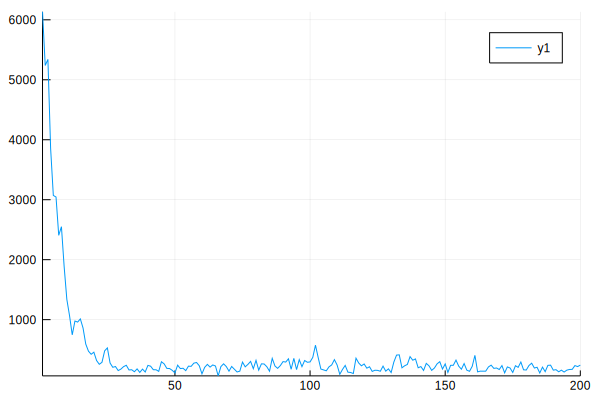

In [27]:
mcMeasure(200, 10, 2000, 5, 1/4)